In [1]:
import random
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tqdm.auto import tqdm
import pickle
import esm
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torch.utils.data.sampler import Sampler
import scipy
from scipy.stats import spearmanr
from sklearn.metrics import r2_score

import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import Sequential
from keras.optimizers import Adam
from keras.layers import LSTM
from numpy2tfrecord import build_dataset_from_tfrecord


In [2]:
class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd
    def forward(self, x):
        return self.lambd(x)

def l2_norm_tns(tns):
    """ l2 normalize the tns """
    return tns / tns.norm(dim=-1,p=2,keepdim=True)

def load_large_file(load_file):
    with open(load_file, 'rb') as f:
        while True:
            try:
                yield pickle.load(f)
            except EOFError:
                break

class protein_model(tf.keras.Model):
    def __init__(self, seq_length, glo_dim, loc_dim):
        super().__init__()
        #glo
        self.lstm1 = tf.keras.layers.Bidirectional(LSTM(units=256,return_sequences=True), input_shape=(seq_length, glo_dim))
        #self.d1    = tf.keras.layers.Dropout(0.2)
        self.lstm2 = tf.keras.layers.Bidirectional(LSTM(units=256, return_sequences=True))
        self.lstm3 = tf.keras.layers.Bidirectional(LSTM(units=256))
        self.glo1  = tf.keras.layers.Dense(512, activation="linear")
        self.glo2  = tf.keras.layers.Dense(256, activation="linear")
        self.glo3  = tf.keras.layers.Dense(128, activation="linear")
        self.glo4  = tf.keras.layers.Dense(64, activation="linear")
        #loc
        self.lstm4 = tf.keras.layers.Bidirectional(LSTM(units=256,return_sequences=True), input_shape=(seq_length, loc_dim))
        #self.d2    = tf.keras.layers.Dropout(0.2)
        self.lstm5 = tf.keras.layers.Bidirectional(LSTM(units=256, return_sequences=True))
        self.lstm6 = tf.keras.layers.Bidirectional(LSTM(units=256))
        self.loc1  = tf.keras.layers.Dense(512, activation="linear")
        self.loc2  = tf.keras.layers.Dense(256, activation="linear")
        self.loc3  = tf.keras.layers.Dense(128, activation="linear")
        self.loc4  = tf.keras.layers.Dense(64, activation="linear")
        #graph
        self.g1    = tf.keras.layers.Dense(2048, input_shape=(3072,),activation="tanh")
        self.g2    = tf.keras.layers.Dense(1024, activation="tanh")
        self.g3    = tf.keras.layers.Dense(512,activation="elu")
        self.g4    = tf.keras.layers.Dense(256, activation="elu")
        self.g5    = tf.keras.layers.Dense(128, activation="elu")
        self.g6    = tf.keras.layers.Dense(64, activation="linear")
        #fc layer
        self.fc1  = tf.keras.layers.Dense(128, input_shape=(64*3,), activation="linear")
        self.fc2  = tf.keras.layers.Dense(64, activation="linear")
        self.fc3  = tf.keras.layers.Dense(32, activation="linear")
        self.fc4  = tf.keras.layers.Dense(1, activation="linear")

    def call(self, input, training):
        x_glo, x_loc, graph_reps = input       
        x_glo = self.lstm1(x_glo)
        x_glo = self.lstm2(x_glo)
        x_glo = self.lstm3(x_glo)
        x_glo = self.glo1(x_glo)
        x_glo = self.glo2(x_glo)
        x_glo = self.glo3(x_glo)
        x_glo = self.glo4(x_glo)
        x_loc = self.lstm4(x_loc)
        x_loc = self.lstm5(x_loc)
        x_loc = self.lstm6(x_loc)
        x_loc = self.loc1(x_loc)
        x_loc = self.loc2(x_loc)
        x_loc = self.loc3(x_loc)
        x_loc = self.loc4(x_loc)        
        graph_reps = self.g1(graph_reps)
        graph_reps = self.g2(graph_reps)
        graph_reps = self.g3(graph_reps)
        graph_reps = self.g4(graph_reps)
        graph_reps = self.g5(graph_reps)
        graph_reps = self.g6(graph_reps)
        x     = tf.concat([x_glo, x_loc, graph_reps], 1)
        x     = self.fc1(x)
        x     = self.fc2(x)
        x     = self.fc3(x)
        x     = self.fc4(x)
        return x

In [3]:
seq_length = 163
glo_dim    = 640
loc_dim    = 164
#max_epochs     = 2000
learning_rate  = 0.0001
dataset = build_dataset_from_tfrecord("./data/tf_train.tfrecord").batch(32).prefetch(1)
model=protein_model(seq_length, glo_dim, loc_dim)
#optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(
       optimizer = Adam(learning_rate=0.0001),
       loss="mse")
#input_shape=([(8,163,640),(8,163,164),(8,3072)])
#model.build(input_shape = input_shape)  
#model.summary()

train_losses = []
for epoch in range(1000):
    for batch in dataset.as_numpy_iterator():
        x_glo,x_loc,y,graph_norm = batch['glo'],batch['loc'],batch['lable'],batch['graph']
        x_glo=tf.convert_to_tensor(x_glo)
        x_loc=tf.convert_to_tensor(x_loc)
        y=tf.convert_to_tensor(y)
        graph_norm=tf.convert_to_tensor(graph_norm)
        # Save the model
        out1=model.train_on_batch([x_glo,x_loc,graph_norm],y)
        train_losses.append(out1)
    print(f'Epoch: {epoch},   Loss: {sum(train_losses) / len(train_losses):4f}')

model.save_weights("./result/tf_best.h5")
#model.load_weights("./result/tf_best.h5") 

Epoch: 0,   Loss: 0.156315
Epoch: 1,   Loss: 0.139824
Epoch: 2,   Loss: 0.133787
Epoch: 3,   Loss: 0.130913
Epoch: 4,   Loss: 0.127805
Epoch: 5,   Loss: 0.124154
Epoch: 6,   Loss: 0.120856
Epoch: 7,   Loss: 0.118092
Epoch: 8,   Loss: 0.114999
Epoch: 9,   Loss: 0.112379
Epoch: 10,   Loss: 0.110551
Epoch: 11,   Loss: 0.108043
Epoch: 12,   Loss: 0.106154
Epoch: 13,   Loss: 0.104411
Epoch: 14,   Loss: 0.102587
Epoch: 15,   Loss: 0.101110
Epoch: 16,   Loss: 0.099642
Epoch: 17,   Loss: 0.098323
Epoch: 18,   Loss: 0.097099
Epoch: 19,   Loss: 0.095939
Epoch: 20,   Loss: 0.094842
Epoch: 21,   Loss: 0.093800
Epoch: 22,   Loss: 0.092804
Epoch: 23,   Loss: 0.091870
Epoch: 24,   Loss: 0.090967
Epoch: 25,   Loss: 0.090123
Epoch: 26,   Loss: 0.089304
Epoch: 27,   Loss: 0.088533
Epoch: 28,   Loss: 0.087787
Epoch: 29,   Loss: 0.087079
Epoch: 30,   Loss: 0.086395
Epoch: 31,   Loss: 0.085740
Epoch: 32,   Loss: 0.085104
Epoch: 33,   Loss: 0.084489
Epoch: 34,   Loss: 0.083891
Epoch: 35,   Loss: 0.083309
Ep

In [74]:
pre_y = []
rel_y = []
dataset_test = build_dataset_from_tfrecord("./data/tf_test.tfrecord").batch(1).prefetch(1)
for batch_test in dataset_test.as_numpy_iterator():
    x_glo_test,x_loc_test,y_test,graph_norm_test = batch_test['glo'],batch_test['loc'],batch_test['lable'],batch_test['graph']
    test_pre = model.predict_on_batch([x_glo_test,x_loc_test,graph_norm_test])
    pre_y.append(test_pre[0][0])
    rel_y.append(y_test[0])

In [ ]:
#Fusion model for Prediction the Effects of Protein Mutations 

r2_score: 0.51
Spearman Correlation with Tuned Parameters:  0.7628987699619669


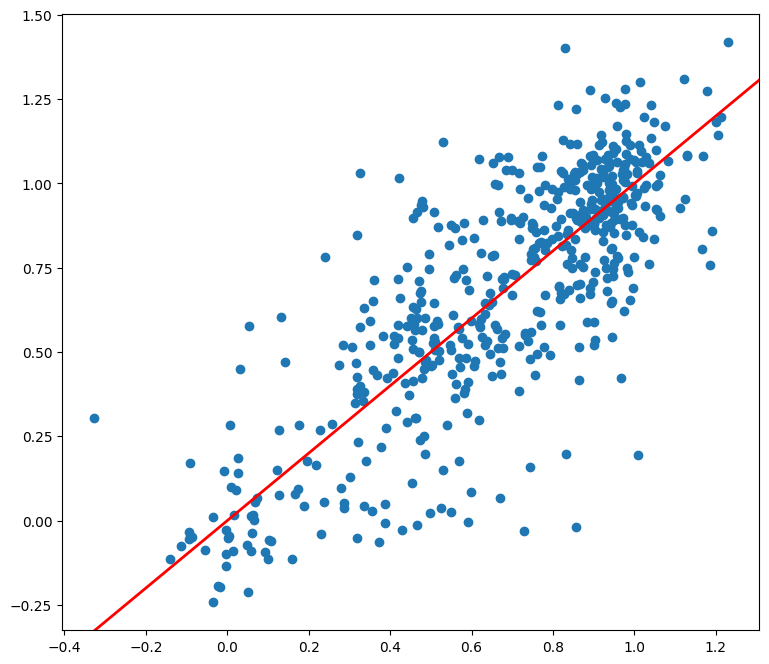

In [76]:
y0 = pd.DataFrame(pre_y)
y1 = pd.DataFrame(rel_y)
corr, p = spearmanr(y0,y1)
#plot
print('r2_score: %.2f'% r2_score(y0, y1))
plt.figure(figsize=(9, 8))
plt.xlim() 
plt.ylim()  
plt.axline((0, 0), slope=1, linewidth=2, color='r')
plt.scatter(y0,y1)
print("Spearman Correlation with Tuned Parameters: ",corr)